# Scripting with chiLife


In [ ]:
! find . -maxdepth 1 -type f  ! -name "*.ipynb" -delete

In [4]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import chilife as xl

# Objective: Identify alternate protein conformational states from AF2 models using chiLife.
> Preface : I believe the workflow presented in this section makes DEER and FRET some of the most powerful tools for modern structural biology.

## Introduction
* The protein we are going to use the CNBD of mouse HCN2 (hyper-polarization-activated cyclic nucleotide-gated ion channel)
* This protein undergoes a conformational change upon ligand binding illustrated here

<img src="https://github.com/mtessmer/chiLife_workshop/blob/main/img/Fig3.1.png?raw=true" style="width: 800px;"/>

  
* We are going to pretend like we know nothing about this structure, which means we will be using AF2 models!
* By default AF2 predicts the ligand bound state of this structure 10/10 times, so if we want to model the other state we are going to have to some convincing.
* Recently several groups have shown you can get AF2 to produce alternate conformations by sub-sampling the MSA used to generate models (1, 2).

e.g. del alamo et al showed this for proteins like the membrane transporter LAT1

<img src="https://github.com/mtessmer/chiLife_workshop/blob/main/img/Fig3.2.png?raw=true" style="width: 800px;"/>

> Note that the majority of structures fall in between the two states and are will often not correspond to biologically significant states.

### Goal: Identify the biologically significant states from an AF2 ensemble using chiLife and DEER data 

* Because this kind of sampling can requires a lot of GPU power, I generated samples ahead of time.
* If you look at the ensemble you can see that it would be pretty hard to destengiush which structure if any correspond to the alternate state.
* We are going to use experimental DEER data to ID the correct structure
> NOTE that the following protocol can be used with ensembles generated using any other method, e.g. Rosetta, MD, etc.


## Experimental Data
* We will also use data from the paper "Double electron–electron resonance reveals cAMP-induced conformational change in HCN channels" which was a collaboration between the Stoll Group and the Zagotta Group here at UW (3).
* Lets start by getting a look at the data.

### References:

1. Alamo, D. del, D. Sala, H.S. Mchaourab, and J. Meiler. 2022. Sampling alternative conformational states of transporters and receptors with AlphaFold2. Elife. 11.
2. Wayment-Steele, H.K., A. Ojoawo, R. Otten, J.M. Apitz, W. Pitsawong, M. Hömberger, S. Ovchinnikov, L. Colwell, and D. Kern. 2023. Predicting multiple conformations via sequence clustering and AlphaFold2. Nature. 1–8.
3. Puljung, M.C., H.A. DeBerg, W.N. Zagotta, and S. Stoll. 2014. Double electron-electron resonance reveals cAMP-induced conformational change in HCN channels. Proc. Natl. Acad. Sci. USA. 111:9816–21.
   

(96, 4)


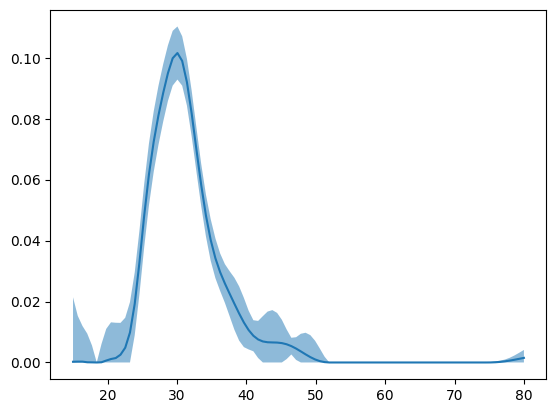

(96, 4)


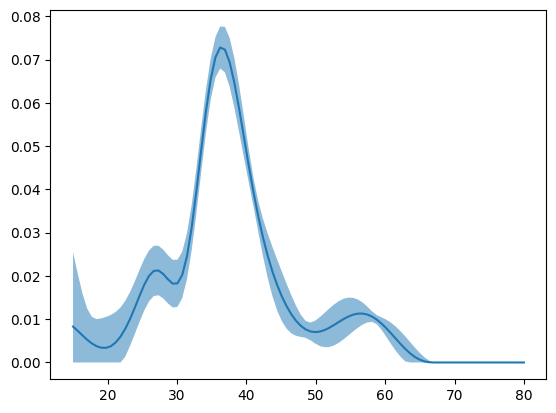

(96, 4)


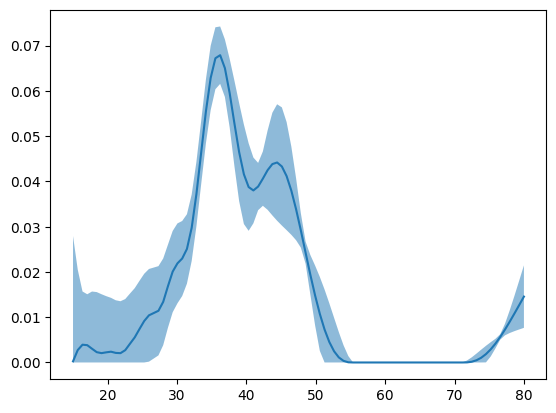

(96, 4)


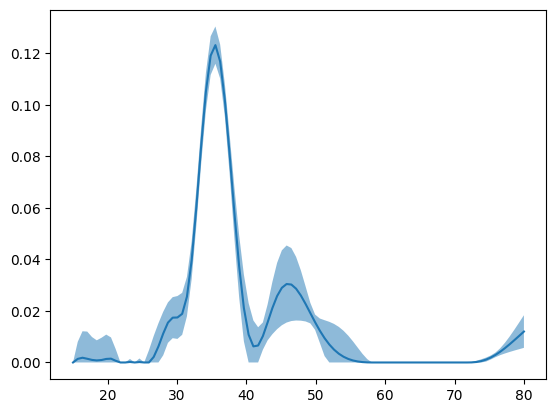

(96, 4)


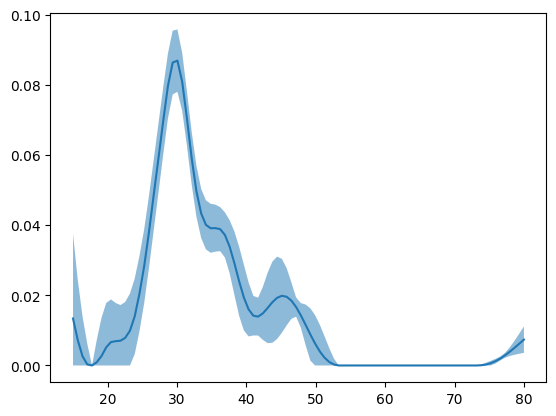

(96, 4)


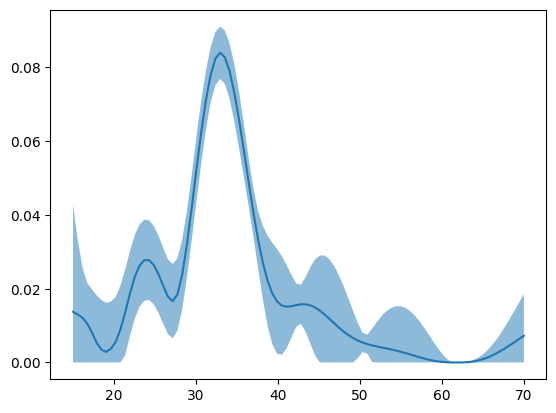

(96, 4)


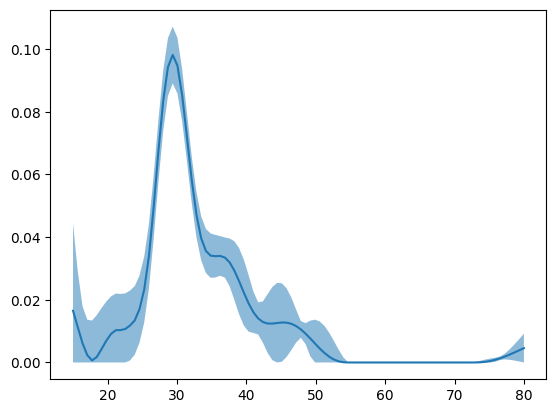

In [5]:
# Build from 1 file
for file in Path('data/HCN-CNBD/DEER Data/').glob('*.txt'):

    data = np.loadtxt(file)
    print(data.shape)
    
    plt.plot(data[:,0], data[:,1])
    plt.fill_between(data[:,0], data[:,2], data[:,3], alpha=0.5)
    plt.show()

## Loading in data

Next, let's load in our data and create a few utility variables to keep track of our site pairs.  

In [6]:
Exp_data = {}
for file in Path('..'):
  Exp_data[file.stem] = np.loadtxt(file)

pairs = {}
for name in Exp_data: 
  pairs[name] = name.split('C')[:2])


sites = set()
for pair in pairs.values():
  sites.update(pair)     

## Loading in AF2 ensemble

* I have packaged the ensemble in an XTC (compressed) format to keep the file size small. We can load it by running:

In [7]:
protein = xl.load_protein('data/HCN-CNBD/HCN-CNBD.pdb', 'data/HCN-CNBD/output/HCN-CNBD.xtc')

## The main script

* Next, we wish to loop through all of our structures and:
    * model spin labels at all the experimental sites
    * predict the distance distributions
    * compare them to the experimental

* to compare distance distributions we will use the overlap metric

$$Overlap = \sum \min(P_{exp}, P_{sim})$$

In [8]:
from tqdm import tqdm
# Create a list to keep track of per-structure scores
all_scores = []

# First we loop through our structures
for idx in tqdm(protein.trajectory):

    # Create spin labels
    SLs = {site: xl.SpinLabel('R1M', site, protein) for site in sites}

    # Create lists to keep track of our overlap scores
    sp_scores = []

    # Loop through our site pairs
    for name, data in Exp_data.items():

        # Get our sites and X-axis
        site1, site2 = pairs[key]
        r = data[:, 0]

        # Predict the distance distribution
        P = xl.distance_distribution(SLs[site1], SLs[site2], r)

        # Calculate the overlap score
        ovlp = np.minimum(P, data[:,1]).sum()

        # Save the score
        site_scores.append(ovlp)

    # Save scores for all sites of this structure
    all_scores.append(sp_scores)

# Create numpy array from the scores 
all_scores = np.array(all_scores)


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:23<00:00,  8.10it/s]


## Selecting the optimal structure

  warnings.warn("Unit cell dimensions not found. "

  warnings.warn("Found no information for attr: '{}'"



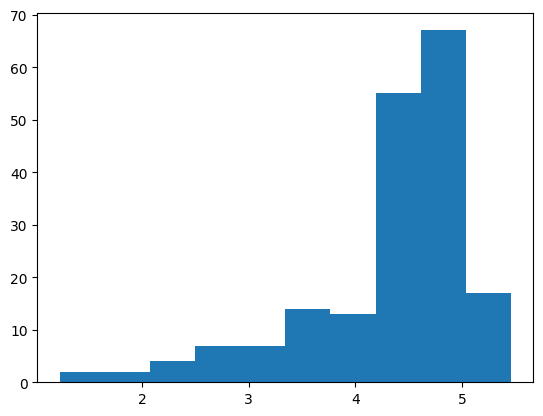

In [9]:
all_scores.sum(axis=1)
plt.hist(all_scores.sum(axis=1))

best_idx = np.argmax(all_scores.sum(axis=1))
protein.trajectory[best_idx]
protein.atoms.write('best_selection.pdb')

## Results
* We can clearly see a shift of the terminal helix, opening the cyclic nucleotide bidning pocket which is exactly what has been seen in crystal structures.
* Notably, none of our DEER distances are on the N-terminal portion of the CNBD, so this location is conjecture, however it is very possible that this conformational change is what regulates downstream activity of the ion channel.



## Concluding Remarks
* There are a lot of details we could change about this protocol, e.g. weighting structures by their pLDDT.


* Because chiLife and AF2 are both python packages, you can integrate this workfolw while during inference if you run AF2 locally or on your institutions HPC.